Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script




In [1]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive

In [2]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset







In [3]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task2']
df = df.rename(columns = {"task1": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexist
1,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [5]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexist'],[0, 1])

In [6]:
#Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()
# Y revisamos como ha quedado el dataframe:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",1
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


## 2.1 - Separamos el dataset en varios conjuntos (Train, Validación y Test)

In [7]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [8]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [9]:
#Lo convertimos en un solo dataset:

TWS = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

TWS = TWS.remove_columns(["__index_level_0__"])

In [10]:
TWS

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

In [11]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['Sexista','No_Sexista']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'Sexista', '1': 'No_Sexista'}, {'Sexista': '0', 'No_Sexista': '1'})

# 3.Descarga del modelo y su tokenizador



In [12]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = 'Twitter/twhin-bert-base'
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=128, truncation = True)

In [14]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
TWS_Encoded = TWS.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [15]:
TWS_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [16]:
#Necesitamos que los objetos sean de tipo torch
TWS_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [17]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 2, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

### 3.1.1 Métricas:

In [19]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [20]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-sexism_detection"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [21]:
# Generamos un objeto Trainer para el entrenamiento:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = TWS_Encoded["train"],
  eval_dataset = TWS_Encoded["val"],
  tokenizer = tokenizer)

In [22]:
gc.collect()
torch.cuda.empty_cache()

In [23]:
#5.Entrenamos nuestro modelo:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.546400,0.498566,0.764342,0.758371
2,0.426400,0.508021,0.791703,0.790063
3,0.316000,0.761986,0.782877,0.782914


TrainOutput(global_step=3399, training_loss=0.43555958841295234, metrics={'train_runtime': 684.8362, 'train_samples_per_second': 39.701, 'train_steps_per_second': 4.963, 'total_flos': 1788431621045760.0, 'train_loss': 0.43555958841295234, 'epoch': 3.0})

### Matriz de Confusión

In [24]:
preds_output = trainer.predict(TWS_Encoded["val"])

In [25]:
preds_output.metrics

{'test_loss': 0.4985661804676056,
 'test_accuracy': 0.764342453662842,
 'test_f1': 0.7583707434176064,
 'test_runtime': 4.2437,
 'test_samples_per_second': 266.982,
 'test_steps_per_second': 33.461}

Text(0.5, 1.0, 'Matriz de confusión')

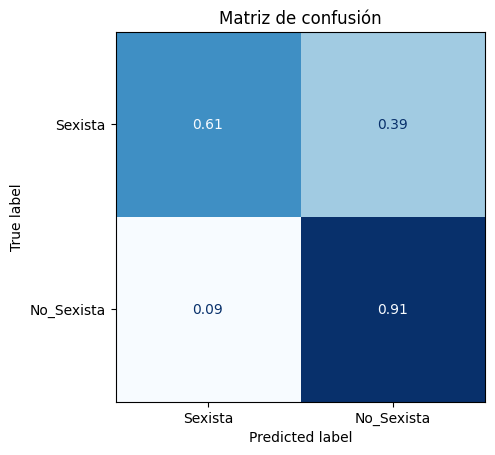

In [26]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["val"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

In [27]:
preds_output = trainer.predict(TWS_Encoded["test"])
preds_output.metrics



{'test_loss': 0.5158655643463135,
 'test_accuracy': 0.7572815533980582,
 'test_f1': 0.7517913334491054,
 'test_runtime': 4.2548,
 'test_samples_per_second': 266.289,
 'test_steps_per_second': 33.374}

Text(0.5, 1.0, 'Matriz de confusión')

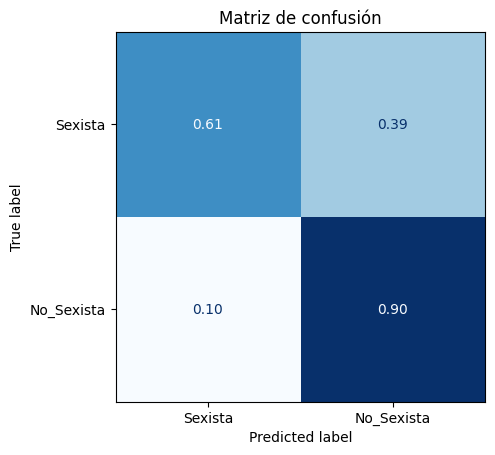

In [28]:
y_preds = np.argmax(preds_output.predictions, axis = 1)
cm = confusion_matrix(TWS_Encoded["test"]['label'], y_preds, normalize = "true")
labels = ['Sexista', 'No_Sexista']
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap = "Blues", values_format = ".2f", colorbar = False)
plt.title("Matriz de confusión")

# Análisis del validation loss

In [29]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [30]:
TWS_Encoded["val"] = TWS_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [31]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [32]:
TWS_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = TWS_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [33]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
33,Sodomizar el sábado es maravilloso. Necesito a alguien(s) con quien sodomizar. https://t.co/j4UB1rHyBW,No_Sexista,Sexista,3.132928
523,Y voy por un culo así el año que viene https://t.co/n41R03x8u6,No_Sexista,Sexista,3.038405
494,"""Ya me divertí""""Ya no quiero juegos""Siempre es lo mismo. El alfa primero, luego el beta con dinero. #MGTOW https://t.co/Oie3CKFvuV",No_Sexista,Sexista,3.022266
1055,Liderando a la activista #WomensRights de Arabia Saudita #LoujainAlhathloul ha sido liberada de prisión después de unos 1.000 días de detención y en medio de la persistente presión internacional para que sea liberada.https://t.co/uOvMOSbYxl,No_Sexista,Sexista,2.824222
179,"#NoEsBromaY como si no fuera suficiente, tendrá que pagar una pensión alimenticia ...https://t.co/5fYh13p2WO",No_Sexista,Sexista,2.788474
251,"@AlleyDalley Tuvo que ser un puritano expresando impulsos reprimidos, estoy seguro",No_Sexista,Sexista,2.778003
304,@sycnan5 Sencillamente hermosa mujer Dios te bendiga siempre por ser la creación más perfecta y maravillosa de Dios para el mundo,No_Sexista,Sexista,2.683020
624,@holliedemi no vuelvas a mandarme un mensaje de nuevo,No_Sexista,Sexista,2.622991
735,@MaxTena1 Manspreading sin marcar paquete... Perfecto resumen de la insulsez de la progresía del Siglo XXI.,No_Sexista,Sexista,2.596188
193,#VaginalToys #PureMature https://t.co/qtc5Oev78p,No_Sexista,Sexista,2.566326


In [34]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
# Ordena y muestra las primeras 10 filas
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
141,$1.50 El Misterio de la Providencia (Puritano de Vintage) por John Flavel https://t.co/TS1sNw3jIC#kindledeales https://t.co/hZGQ6rYEoB,Sexista,Sexista,0.041772
119,"Fue un paseo frígido por la tarde, pero estoy decidido a no quedarme en el sofá todo el descanso. https://t.co/uJVKneDdSD",Sexista,Sexista,0.042462
905,"Es seguro decir que 2020 fue un año de gran importancia histórica. ¡Gracias por compartir la esperanza que nos dio Jesucristo para ayudar a estos hombres, mujeres y niños a hacer sus propias historias! Disfrute de nuestro Informe Anual de 2020 a continuación. #HistoryInTheMakinghttps://t.co/33UoegDbZ5 https://t.co/NzTleNfLTv",Sexista,Sexista,0.042819
188,Dia rico #mazatlan #lamanada #playa https://t.co/tav5FYOZ1B,Sexista,Sexista,0.043459
875,". @NYCDHS’s Code Blue está en vigor hasta mañana, martes 15 de diciembre a las 8:00 AM. Si usted ve a una persona sin hogar fuera en estas frías temperaturas, por favor llámenos al 311. https://t.co/m1EsUqHhOZ",Sexista,Sexista,0.043614
1075,Ok está fotico se merece estar aquí https://t.co/fv7GAicvNn,Sexista,Sexista,0.043987
787,"#PixarSoul es arte: es abstracta y sencilla a la vez, en momentos divertida y dulce, en momentos ácida y triste. Un viaje emocional y emocionante que sin duda merece el reconocimiento de mejor película de animación de este año.",Sexista,Sexista,0.044014
393,Resulta que hoy es el día de la juventud y no me queda más que felicitar al único que lo merece. Feliz día Gai! que la llama de tu juventud nunca se apague :),Sexista,Sexista,0.044261
833,Sentir que tienes un hogar lejos de tu lugar de nacimiento... se me viene a la cabeza la Virgen Maria embarazada pidiendo posada donde traer a la vida a Jesús... ver a Jesús en todos. #Navidad https://t.co/DAt08d2UzT,Sexista,Sexista,0.044540
377,"@CoronelHMejia Mi Coronel. Para sumerced y todos los suyos una Feliz Navidad, mucha salud y prosperidad infinita. Dios Todopoderoso sabe que Ud es un buen hombre, lo que tanto necesita nuestra patria.",Sexista,Sexista,0.044689


In [35]:
model.save_pretrained(
  os.path.join(path_model, 'Twitter/twhin-finetuned-TaskA'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'Twitter/twhin-finetuned-TaskA'))

('/content/drive/MyDrive/Twitter/twhin-finetuned-TaskA/tokenizer_config.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-TaskA/special_tokens_map.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-TaskA/tokenizer.json')